In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
torch.manual_seed(0)

# Download data, prepare data loaders

In [3]:
# Download train and test data:

training_data_ = datasets.MNIST(
    root="/Users/lucas/Documents/Data/",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="/Users/lucas/Documents/Data/",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
# Split training data into train and validation:

train_split, val_split = torch.utils.data.random_split(training_data_, [50000, 10000], generator=torch.Generator().manual_seed(42))

print(f'Train set:      {len(train_split)} samples')
print(f'Validation set: {len(val_split)} samples')
print(f'Test set:       {len(test_data)} samples')

Train set:      50000 samples
Validation set: 10000 samples
Test set:       10000 samples


In [5]:
# Create data loaders with a given batch size:

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_split, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_split, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Check first batch:
X, y = next(iter(test_dataloader))
print(f"X: shape {X.shape} type {X.dtype}")
print(f"y: shape {y.shape} type {y.dtype}")

X: shape torch.Size([64, 1, 28, 28]) type torch.float32
y: shape torch.Size([64]) type torch.int64


# 1) Baseline: Logistic regression

We first train a simple logistic regression model, which can be used as our baseline.

### Define model:

In [6]:
device = 'cpu'

class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28*28, 10)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

model = LogisticRegression().to(device)

print(model)

LogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [7]:
# Check number of parameters:

def number_of_parameters(model):
    return sum(torch.numel(p) for p in model.parameters())

print(f'Model {model.__class__.__name__} contains {number_of_parameters(model)} parameters')

Model LogisticRegression contains 7850 parameters


### Define a loss function (Cross-Entropy):

Note that nn.CrossEntropyLoss() already performs a softmax operation, so no need to add softmax() in the model 

In [8]:
loss_fn = nn.CrossEntropyLoss()

### Training and evaluation functions:

In [9]:
def train_model(model, optimizer, num_epochs, verbose = True):
    '''
        Train a model, given an optimizer and a number of epochs.
        Computes validation loss and accuracy after each epoch, and prints train/validation metrics.
        Returns per-iteration train and validation losses, for plotting.
    '''
    
    model.train()

    train_loss_log = []
    val_loss_log = []

    t = time.time()

    for i_epoch in range(num_epochs):

        epoch_loss = 0

        for i_batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            epoch_loss += batch_loss * len(y)

        # calculate average loss of this epoch:
        mean_epoch_loss = epoch_loss/len(train_split)  

        # calculate validation loss and accuracy:
        val_loss, val_acc = evaluate_model(val_dataloader)
        model.train()
        
        # print and save metrics:
        if verbose:
            print(f" epoch: {i_epoch+1:>2}, training loss: {mean_epoch_loss:.3f}, validation loss {val_loss:.3f}, validation accuracy {val_acc:.3f}")

        train_loss_log.append(mean_epoch_loss)
        val_loss_log.append(val_loss)

    # Calculate average time per epoch:
    time_per_epoch = (time.time()-t)/num_epochs
    
    if verbose:
        print(f'\nAverage time per epoch: {time_per_epoch:.3f}s')
    
    return train_loss_log, val_loss_log

In [10]:
def evaluate_model(data_loader):
    ''' Calculates average loss and accuracy over a dataset'''
    model.eval()
    
    num_correct = 0
    total_loss = 0
    num_samples = 0

    for i_batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        # Prediction on batch X:
        with torch.no_grad():
            pred = model(X)
            
        # Predicted class indexes:
        pred_idx = torch.argmax(pred, dim=1)
        
        # Batch loss:
        batch_loss = loss_fn(pred, y).item()

        total_loss += batch_loss * len(y)
        num_correct += torch.sum(pred_idx == y).item()
        num_samples += len(y)

    average_loss = total_loss/num_samples
    accuracy = num_correct/num_samples
        
    return average_loss, accuracy

In [11]:
def print_overall_metrics():
    ''' Prints loss and accuracy for train, validation and test sets'''
    average_loss, accuracy = evaluate_model(train_dataloader)
    print(f"train loss:      {average_loss:.5f}, accuracy: {accuracy:.5f}")

    average_loss, accuracy = evaluate_model(val_dataloader)
    print(f"validation loss: {average_loss:.5f}, accuracy: {accuracy:.5f}")

    average_loss, accuracy = evaluate_model(test_dataloader)
    print(f"test loss:       {average_loss:.5f}, accuracy: {accuracy:.5f}")

### Train model using SGD:

In [12]:
# Re-instantiate model to re-initialize weights:
model = LogisticRegression().to(device)

# Define optimizer:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# Define number of epochs:
num_epochs = 50

# Train model:
train_loss_log, val_loss_log = train_model(model, optimizer, num_epochs)

 epoch:  1, training loss: 0.501, validation loss 0.373, validation accuracy 0.897
 epoch:  2, training loss: 0.345, validation loss 0.341, validation accuracy 0.906
 epoch:  3, training loss: 0.319, validation loss 0.328, validation accuracy 0.907
 epoch:  4, training loss: 0.306, validation loss 0.318, validation accuracy 0.910
 epoch:  5, training loss: 0.297, validation loss 0.312, validation accuracy 0.912
 epoch:  6, training loss: 0.291, validation loss 0.309, validation accuracy 0.913
 epoch:  7, training loss: 0.286, validation loss 0.306, validation accuracy 0.914
 epoch:  8, training loss: 0.282, validation loss 0.305, validation accuracy 0.915
 epoch:  9, training loss: 0.279, validation loss 0.302, validation accuracy 0.915
 epoch: 10, training loss: 0.276, validation loss 0.304, validation accuracy 0.915
 epoch: 11, training loss: 0.274, validation loss 0.300, validation accuracy 0.916
 epoch: 12, training loss: 0.271, validation loss 0.300, validation accuracy 0.917
 epo

In [13]:
print_overall_metrics()

train loss:      0.24101, accuracy: 0.93456
validation loss: 0.29551, accuracy: 0.91940
test loss:       0.26690, accuracy: 0.92580


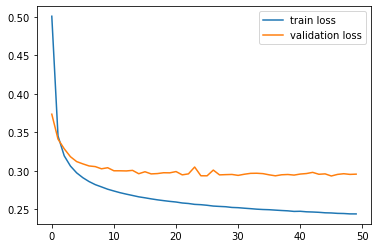

In [14]:
# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

Logistic regression gives a test accuracy of 0.926, which we can use as our baseline. We can visualize the results on a few test images:

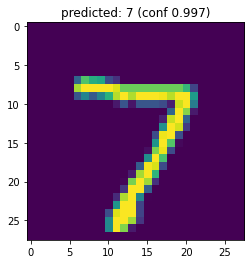

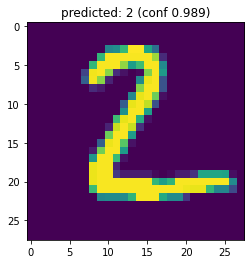

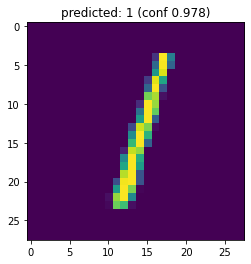

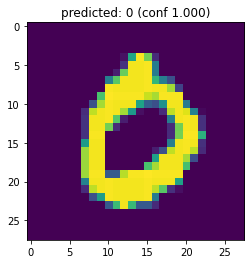

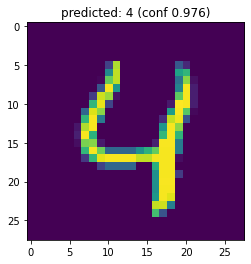

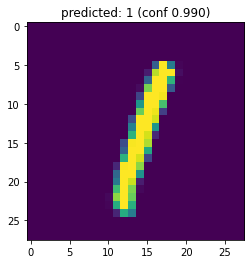

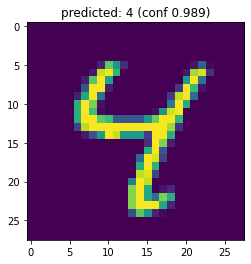

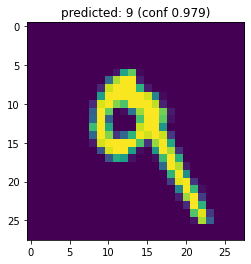

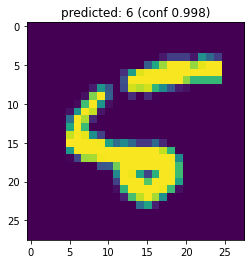

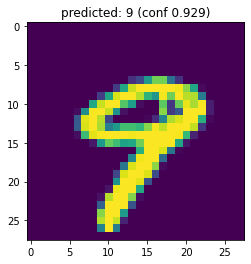

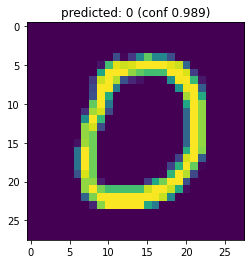

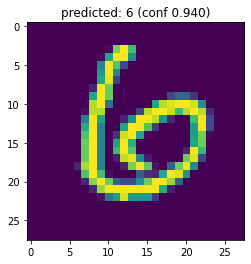

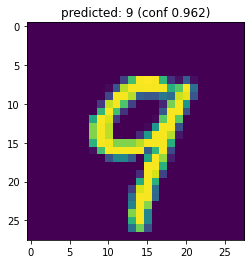

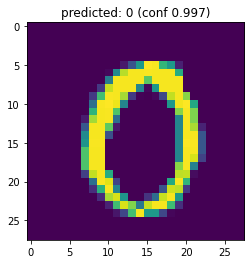

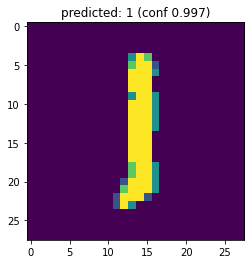

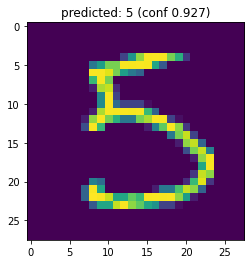

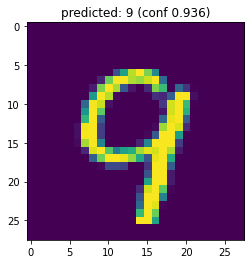

In [15]:
# Plot a few examples on test set:

model.eval()

softmax_fn = torch.nn.Softmax(dim=0)

X, y = next(iter(test_dataloader))  # load 1st test batch

X, y = X.to(device), y.to(device)

# Predict batch:
with torch.no_grad():
    pred_batch = model(X)

for i, (x, pred, true_label) in enumerate(zip(X, pred_batch, y)):

    softmax_ = softmax_fn(pred)
    
    pred_idx = torch.argmax(pred)  # predicted class index
    conf = softmax_[pred_idx]      # prediction confidence
    
    plt.figure()
    plt.imshow(x.squeeze())
    plt.title(f"predicted: {pred_idx.item()} (conf {conf:.3f})")
    
    if i > 15:
        break

### Save model:

In [16]:
torch.save(model.state_dict(), './saved_models/logistic_regression.pt')

# 2) Multi-Layer Perceptron (1 hidden layer)

We train a simple Multi-Layer Perceptron (MLP) with 1 hidden layer, and ReLU activation function. We train the model with various optimizers and evaluate the results

In [17]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        out = self.linear_relu_stack(x)
        return out 

model = MLP().to(device)

print(model)
print(f'Model {model.__class__.__name__} contains {number_of_parameters(model)} parameters')

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)
Model MLP contains 814090 parameters


## 2.1) SGD optimizer

In [18]:
model = MLP().to(device)

# Optimizer:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

num_epochs = 50
train_loss_log, val_loss_log = train_model(model, optimizer, num_epochs)

 epoch:  1, training loss: 0.442, validation loss 0.314, validation accuracy 0.906
 epoch:  2, training loss: 0.224, validation loss 0.202, validation accuracy 0.942
 epoch:  3, training loss: 0.166, validation loss 0.179, validation accuracy 0.947
 epoch:  4, training loss: 0.131, validation loss 0.141, validation accuracy 0.958
 epoch:  5, training loss: 0.108, validation loss 0.124, validation accuracy 0.963
 epoch:  6, training loss: 0.091, validation loss 0.117, validation accuracy 0.965
 epoch:  7, training loss: 0.079, validation loss 0.114, validation accuracy 0.967
 epoch:  8, training loss: 0.069, validation loss 0.101, validation accuracy 0.969
 epoch:  9, training loss: 0.060, validation loss 0.120, validation accuracy 0.962
 epoch: 10, training loss: 0.054, validation loss 0.114, validation accuracy 0.964
 epoch: 11, training loss: 0.048, validation loss 0.090, validation accuracy 0.973
 epoch: 12, training loss: 0.043, validation loss 0.085, validation accuracy 0.974
 epo

train loss:      0.00326, accuracy: 0.99998
validation loss: 0.07742, accuracy: 0.97650
test loss:       0.06288, accuracy: 0.98180


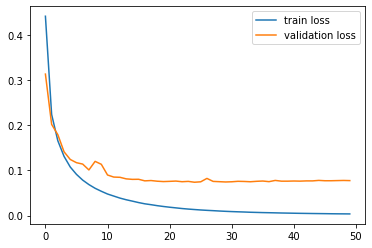

In [19]:
print_overall_metrics()

# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

The MLP gives a test accuracy of 0.982, which is a good improvement compared to logistic regression (0.926), and an impressive result overall for such a simple network. However the training loss looks a bit slow to converge, let's see if we can get a better result (or a similar result with fewer iterations) with a different optimizer:

## 2.2) Adam optimizer

In [20]:
model = MLP().to(device)

# Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
train_loss_log, val_loss_log = train_model(model, optimizer, num_epochs)

 epoch:  1, training loss: 0.247, validation loss 0.157, validation accuracy 0.953
 epoch:  2, training loss: 0.092, validation loss 0.103, validation accuracy 0.968
 epoch:  3, training loss: 0.059, validation loss 0.090, validation accuracy 0.972
 epoch:  4, training loss: 0.040, validation loss 0.086, validation accuracy 0.974
 epoch:  5, training loss: 0.027, validation loss 0.068, validation accuracy 0.980
 epoch:  6, training loss: 0.020, validation loss 0.087, validation accuracy 0.975
 epoch:  7, training loss: 0.016, validation loss 0.073, validation accuracy 0.979
 epoch:  8, training loss: 0.013, validation loss 0.095, validation accuracy 0.974
 epoch:  9, training loss: 0.012, validation loss 0.079, validation accuracy 0.977
 epoch: 10, training loss: 0.009, validation loss 0.100, validation accuracy 0.975
 epoch: 11, training loss: 0.009, validation loss 0.088, validation accuracy 0.977
 epoch: 12, training loss: 0.008, validation loss 0.094, validation accuracy 0.978
 epo

train loss:      0.00056, accuracy: 0.99982
validation loss: 0.15425, accuracy: 0.98150
test loss:       0.15611, accuracy: 0.98160


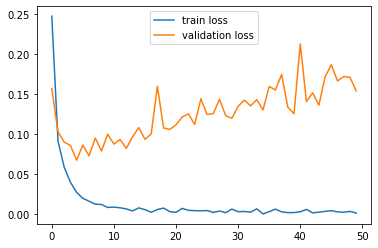

In [21]:
print_overall_metrics()

# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

Adam gives a much faster convergence, reaching a training loss of 0.004 in 14 iterations instead of 50 for SGD. However as we can see in the validation loss, the model starts overfitting after ~10 iterations. One simple way to overcome this is to simply apply early-stopping, i.e. stop iterating after 10 epochs:

In [22]:
model = MLP().to(device)

# Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
train_loss_log, val_loss_log = train_model(model, optimizer, num_epochs, verbose=False)

print_overall_metrics()

train loss:      0.01402, accuracy: 0.99588
validation loss: 0.09629, accuracy: 0.97610
test loss:       0.07469, accuracy: 0.97950


Another strategy to avoid overfitting is to add weight decay to the network:

train loss:      0.06509, accuracy: 0.98436
validation loss: 0.09921, accuracy: 0.97220
test loss:       0.08534, accuracy: 0.97640


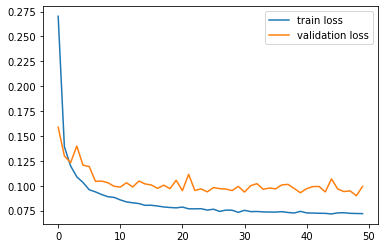

In [23]:
model = MLP().to(device)

# Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

num_epochs = 50
train_loss_log, val_loss_log = train_model(model, optimizer, num_epochs, verbose=False)

print_overall_metrics()

# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

A more common strategy is to add dropout to the model:

In [24]:
class MLP_dropout(nn.Module):
    def __init__(self):
        super(MLP_dropout, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        out = self.linear_relu_stack(x)
        return out 

 epoch:  1, training loss: 0.296, validation loss 0.154, validation accuracy 0.954
 epoch:  2, training loss: 0.135, validation loss 0.111, validation accuracy 0.967
 epoch:  3, training loss: 0.102, validation loss 0.096, validation accuracy 0.970
 epoch:  4, training loss: 0.084, validation loss 0.087, validation accuracy 0.973
 epoch:  5, training loss: 0.069, validation loss 0.077, validation accuracy 0.976
 epoch:  6, training loss: 0.063, validation loss 0.077, validation accuracy 0.977
 epoch:  7, training loss: 0.056, validation loss 0.072, validation accuracy 0.977
 epoch:  8, training loss: 0.049, validation loss 0.078, validation accuracy 0.977
 epoch:  9, training loss: 0.043, validation loss 0.079, validation accuracy 0.978
 epoch: 10, training loss: 0.040, validation loss 0.088, validation accuracy 0.976
 epoch: 11, training loss: 0.039, validation loss 0.080, validation accuracy 0.979
 epoch: 12, training loss: 0.038, validation loss 0.079, validation accuracy 0.979
 epo

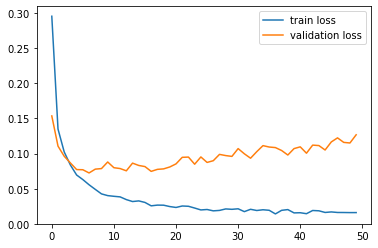

In [25]:
model = MLP_dropout().to(device)

# Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
train_loss_log, val_loss_log = train_model(model, optimizer, num_epochs)

print_overall_metrics()

# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

### Save model:

In [26]:
torch.save(model.state_dict(), './saved_models/MLP.pt')

# 3) Deep vs wide networks

We compare deep vs wide networks, with approximately the same number of parameters

In [27]:
class MLP_wide(nn.Module):
    def __init__(self):
        super(MLP_wide, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 2048),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(2048, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        out = self.linear_relu_stack(x)
        return out 

model = MLP_wide().to(device)

print(f'Model {model.__class__.__name__} contains {number_of_parameters(model)} parameters')

Model MLP_wide contains 1628170 parameters


In [28]:
class MLP_deep(nn.Module):
    def __init__(self):
        super(MLP_deep, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        out = self.linear_relu_stack(x)
        return out 

model = MLP_deep().to(device)

print(f'Model {model.__class__.__name__} contains {number_of_parameters(model)} parameters')

Model MLP_deep contains 1596426 parameters


 epoch:  1, training loss: 0.266, validation loss 0.147, validation accuracy 0.955
 epoch:  2, training loss: 0.125, validation loss 0.107, validation accuracy 0.967
 epoch:  3, training loss: 0.093, validation loss 0.091, validation accuracy 0.971
 epoch:  4, training loss: 0.074, validation loss 0.094, validation accuracy 0.972
 epoch:  5, training loss: 0.064, validation loss 0.082, validation accuracy 0.976
 epoch:  6, training loss: 0.060, validation loss 0.079, validation accuracy 0.977
 epoch:  7, training loss: 0.050, validation loss 0.073, validation accuracy 0.980
 epoch:  8, training loss: 0.043, validation loss 0.079, validation accuracy 0.980
 epoch:  9, training loss: 0.045, validation loss 0.080, validation accuracy 0.979
 epoch: 10, training loss: 0.042, validation loss 0.077, validation accuracy 0.980
 epoch: 11, training loss: 0.034, validation loss 0.079, validation accuracy 0.979
 epoch: 12, training loss: 0.036, validation loss 0.088, validation accuracy 0.979
 epo

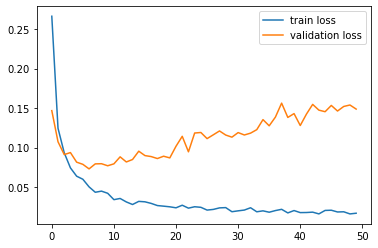

In [29]:
model = MLP_wide().to(device)

# Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
train_loss_log, val_loss_log = train_model(model, optimizer, num_epochs, verbose=True)

print_overall_metrics()

# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

 epoch:  1, training loss: 0.351, validation loss 0.140, validation accuracy 0.958
 epoch:  2, training loss: 0.173, validation loss 0.128, validation accuracy 0.963
 epoch:  3, training loss: 0.143, validation loss 0.121, validation accuracy 0.964
 epoch:  4, training loss: 0.124, validation loss 0.096, validation accuracy 0.973
 epoch:  5, training loss: 0.116, validation loss 0.099, validation accuracy 0.973
 epoch:  6, training loss: 0.102, validation loss 0.102, validation accuracy 0.972
 epoch:  7, training loss: 0.099, validation loss 0.085, validation accuracy 0.978
 epoch:  8, training loss: 0.091, validation loss 0.082, validation accuracy 0.977
 epoch:  9, training loss: 0.088, validation loss 0.083, validation accuracy 0.978
 epoch: 10, training loss: 0.084, validation loss 0.084, validation accuracy 0.978
 epoch: 11, training loss: 0.080, validation loss 0.088, validation accuracy 0.980
 epoch: 12, training loss: 0.081, validation loss 0.079, validation accuracy 0.978
 epo

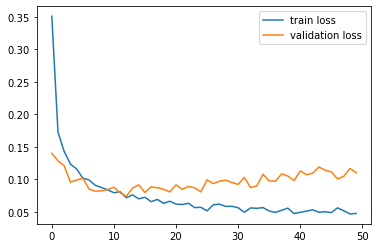

In [30]:
model = MLP_deep().to(device)

# Optimizer:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
train_loss_log, val_loss_log = train_model(model, optimizer, num_epochs, verbose=True)

print_overall_metrics()

# Plot train and validation losses:
plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

The 2 networks have similar performance, however the deep network tend to overfit less than the wide network

[6. 4.] [432. 288.]


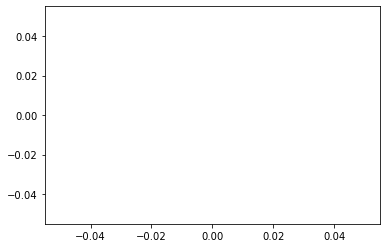

In [34]:
plt.figure()
plt.plot()

fig = plt.gcf()
size = fig.get_size_inches()*fig.dpi # size in pixels
print(fig.get_size_inches(), size)

In [35]:
plt.rcParams['figure.figsize']

[6.0, 4.0]

In [36]:
fig.get_size_inches()

array([6., 4.])